In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import power_divergence

%matplotlib inline

In [14]:
class TDigest():
    
    def __init__(self, k, method):
        self.k = k
        self.klasts = []
        
        self.kminus_one_cdf = None
        self.kth_cdf = None
        
        self.kminus_one_counts = None
        self.kth_counts = None
        
        self.method = method
        self.statistics = None
        self.p_value = None
        
    def add(self, x):
        self.klasts.append(x)
        if len(self.klasts) > self.k:
            self.klasts.pop(0)
            
        self._comp_kminus_one_cdf()
        self._comp_k_cdf()
        
    def get_stats(self):
        self._comp_statistics()
        return self.statistics, self.p_value
            
    def _comp_kminus_one_cdf(self):
        if len(self.klasts) >= self.k:
            kminus_one = self.klasts[:-1]
            kminus_one_heap = np.array(kminus_one).flatten()
            
            ecdf = ECDF(kminus_one_heap)
            self.kminus_one_cdf = ecdf(np.linspace(-3.0, 3.0, 100))
            
            counts, edges = np.histogram(kminus_one_heap, bins=20, range=(-2.0, 2.0), density=False)
            self.kminus_one_counts = counts
        
    def _comp_k_cdf(self):
        if len(self.klasts) >= self.k:
            kth = self.klasts[-1]
            
            ecdf = ECDF(kth)
            self.kth_cdf = ecdf(np.linspace(-3.0, 3.0, 100))
            
            counts, edges = np.histogram(kth, bins=20, range=(-2.0, 2.0), density=False)
            self.kth_counts = counts
            
    def _comp_statistics(self):
        if self.method == 'ks':
            self.statistics, self.p_value = stats.ks_2samp(self.kminus_one_cdf, self.kth_cdf)
        elif self.method == 'gtest':
            self.statistics, self.p_value = power_divergence(self.kth_cdf, self.kminus_one_cdf, lambda_='log-likelihood')
        else:
            raise Exception('Unknown method. Please provide KS or GTEST.')


def simulation(nobs_step, nobs_total, method, k):
    nobs_current = 0
    step = 0
    tdigest = TDigest(k=k, method=method)
    statistics = []
    p_values = []
    xc = []
    while nobs_current <= nobs_total:
        # make a step
        step += 1
        trigger = np.random.random()
        if trigger > 0.9:
            #print('SHOULD BE AN ANOMALY!')
            xc.append(step)
        step_values = np.random.normal((lambda x: 1 if x < 0.9 else 5)(trigger), 5, nobs_step)
        tdigest.add(step_values)
        nobs_current += nobs_step

        if step >= k:
            stat, p_value = tdigest.get_stats()
            statistics.append(stat)
            p_values.append(p_value)
            #print('STEP: {step}\nSTATISTICS: {stat}\nP-VALUE: {p_value}\n---'.format(**{'step':step, 'stat':stat, 'p_value':p_value}))
        else:
            pass
            #print('STEP: {step}\nCOLLECTING DATA...\n---'.format(**{'step':step}))
    for x in xc:
        plt.axvline(x)
    print(step)
    print(len(statistics)+10)
    plt.plot(range(k, len(statistics)+10), statistics, 'ro')
    print('TOTAL NUMBER of ANOMALIES: ', len(xc))
    plt.show()    

76
77
TOTAL NUMBER of ANOMALIES:  8


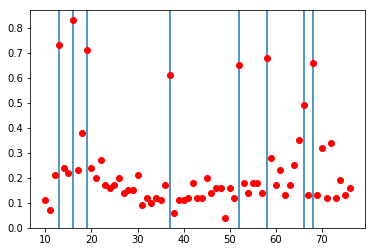

In [15]:
np.random.seed(1)
simulation(nobs_step=200, nobs_total=15000, method='ks', k=10)